In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os

In [48]:
from google.colab import drive
drive.mount('/content/drive')
image1_path = "/content/drive/MyDrive/image1.png"
image2_path = "/content/drive/MyDrive/image2.png"
image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

if image1 is None or image2 is None:
    print("Error")
else:
    print("loaded from Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loaded from Google Drive!


In [49]:
def compute_img_gradients(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #using soble
    Gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = np.sqrt(Gx**2 + Gy**2)
    direction = np.arctan2(Gy, Gx) * 180 / np.pi
    direction = np.mod(direction + 180, 180) - 180

    return magnitude, direction

In [50]:
def compute_hog(image, cell_size=8, threshold=5):

    mag, angle = compute_img_gradients(image)

    #checking gradients
    mag[mag < threshold] = 0

    h, w = mag.shape
    grid_h, grid_w = h // cell_size, w // cell_size
    histogram_magnitude = np.zeros((grid_h, grid_w, 6))
    histogram_count = np.zeros((grid_h, grid_w, 6))


    bins = np.array([-15, 15, 45, 75, 105, 135, 165])

    for i in range(grid_h):
        for j in range(grid_w):

            cell_mag = mag[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            cell_angle = angle[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]

            for k in range(6):
                mask = (cell_angle >= bins[k]) & (cell_angle < bins[k + 1] if k < 5 else cell_angle < 165)
                #magnitude
                histogram_magnitude[i, j, k] = np.sum(cell_mag[mask])
                #getting occcurences
                histogram_count[i, j, k] = np.sum(mask)

    return histogram_magnitude, histogram_count

In [51]:
def represent_hog_images(image, histogram, cell_size=4, title="HOG Features"):

    h, w, bins = histogram.shape
    Y, X = np.mgrid[0:h, 0:w]  # Grid points
    angles = np.array([-15, 15, 45, 75, 105, 135])

    plt.figure(figsize=(10, 6))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray_image, cmap='gray')

    #superimpose multiple quiver plots
    for k in range(6):
        U, V = np.zeros((h, w)), np.zeros((h, w))
        for i in range(h):
            for j in range(w):
                theta = np.deg2rad(angles[k] + 90)
                #making it perpendicular 90degrees
                U[i, j] = np.cos(theta) * histogram[i, j, k]
                V[i, j] = np.sin(theta) * histogram[i, j, k]

        #normalization
        max_mag = np.max(np.abs(U) + np.abs(V))
        if max_mag > 0:
            U = (U / max_mag) * 5
            V = (V / max_mag) * 5

        plt.quiver(X * cell_size, Y * cell_size, U, V, angles='xy', scale_units='xy', scale=1, color='red')

    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()


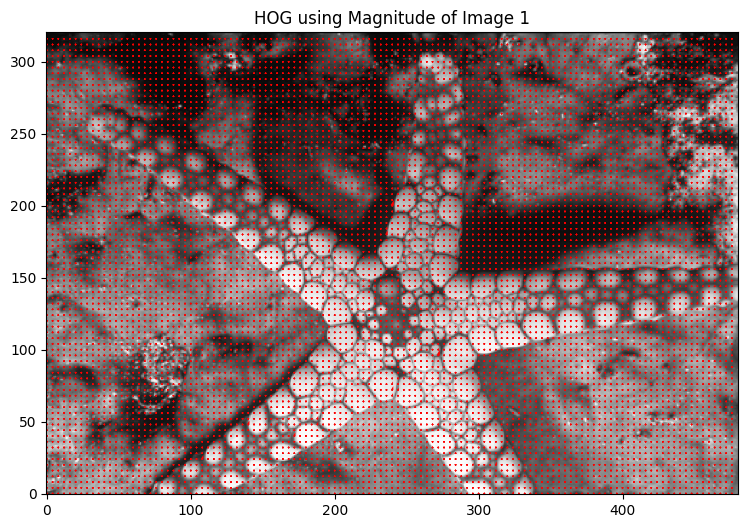

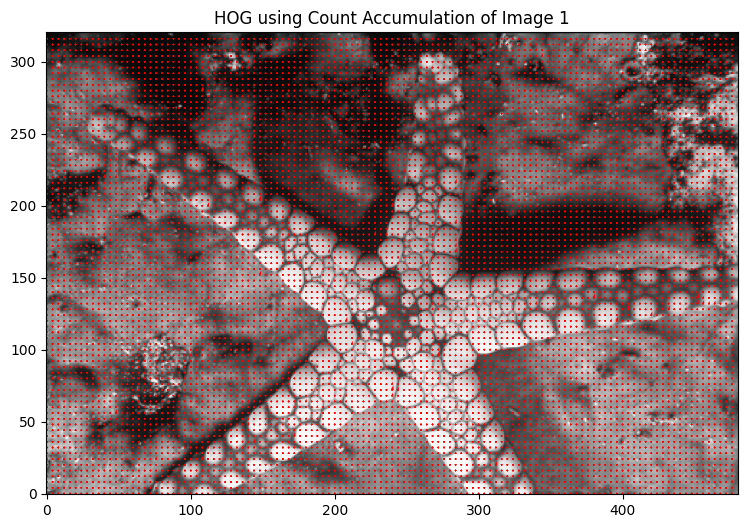

Visualizing HOG for Image 2:


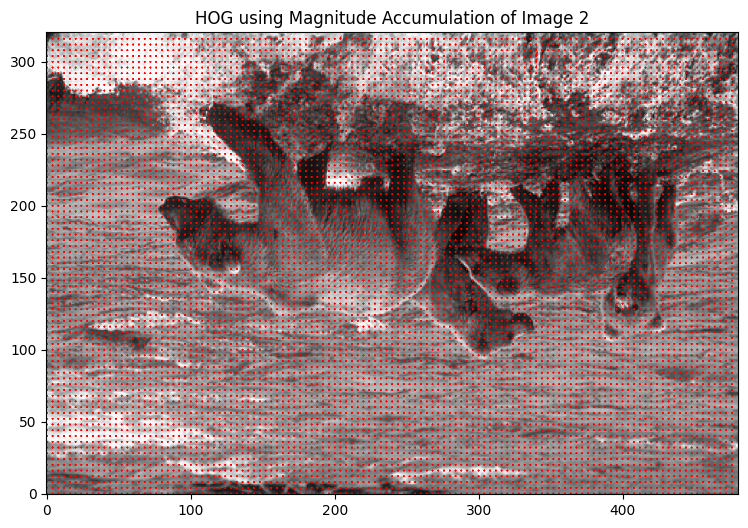

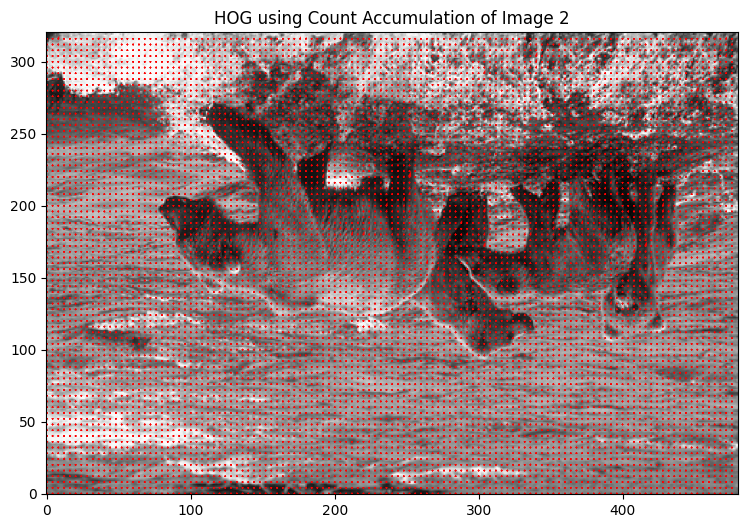

In [52]:
hist_magnitude1, hist_count1 = compute_hog(image1, cell_size=4)
represent_hog_images(image1, hist_magnitude1, title="HOG using Magnitude of Image 1")
represent_hog_images(image1, hist_count1, title="HOG using Count Accumulation of Image 1")
hist_magnitude2, hist_count2 = compute_hog(image2, cell_size=4)
print("Visualizing HOG for Image 2:")
represent_hog_images(image2, hist_magnitude2, title="HOG using Magnitude Accumulation of Image 2")
represent_hog_images(image2, hist_count2, title="HOG using Count Accumulation of Image 2")


# New Section